In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score
from IPython.display import clear_output

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './shallow_nn_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

2024-04-14 22:00:49.048294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 22:00:50.079472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_9906/3685965652.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Tuning hyperparameters 

In [2]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],  # Number of hidden units
    'activation': ['relu', 'tanh', 'logistic'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength (L2 penalty)
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
}    

In [3]:

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Tunning to each specific set

## Under Sampling - No selection

In [4]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



2024-04-14 22:00:51.000751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Reloading Tuner from ./shallow_nn_out/under_no_sel_shallow_nn/tuner0.json


2024-04-14 22:00:51.178210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 22:00:51.178564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 22:00:51.180701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
y_pred = model.predict(X_test) > 0.5
test_loss, test_acc = model.evaluate(X_test, y_test)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')

#save the test recall, f1, precision and accuracy
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_test_recall_f1_precision_accuracy.txt', 'w') as f:
    f.write(f'Test recall: {test_recall}\nTest f1: {test_f1}\nTest precision: {test_precision}\nTest accuracy: {test_accuracy}\n')
clear_output()

print("Test Set")
print(f'F1 score: {test_f1}')
print(f'Accuracy score: {test_acc}')
print(f'Loss score: {test_loss}')
print(f'Precision score: {test_precision}')
print(f'Recall score: {test_recall}')



Test Set
F1 score: 0.07281323877068557
Accuracy score: 0.9606552720069885
Loss score: 0.130936399102211
Precision score: 0.03794972893050764
Recall score: 0.8953488372093024


# Plot of Training and Validation Accuracy/Loss

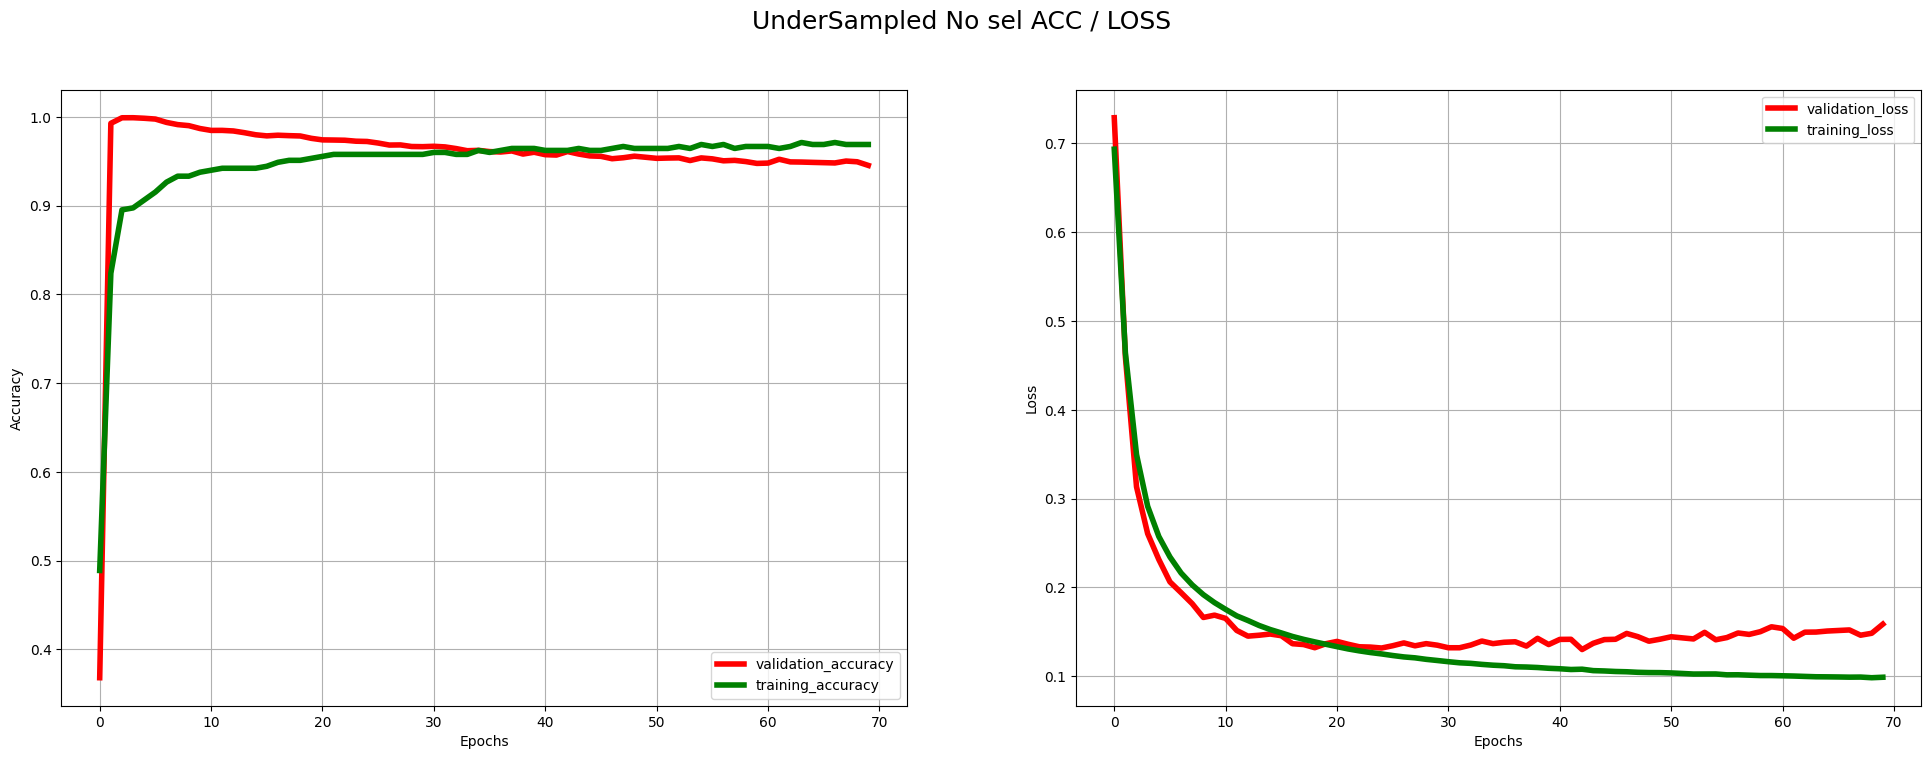

In [6]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

   1/3116 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 550us/step


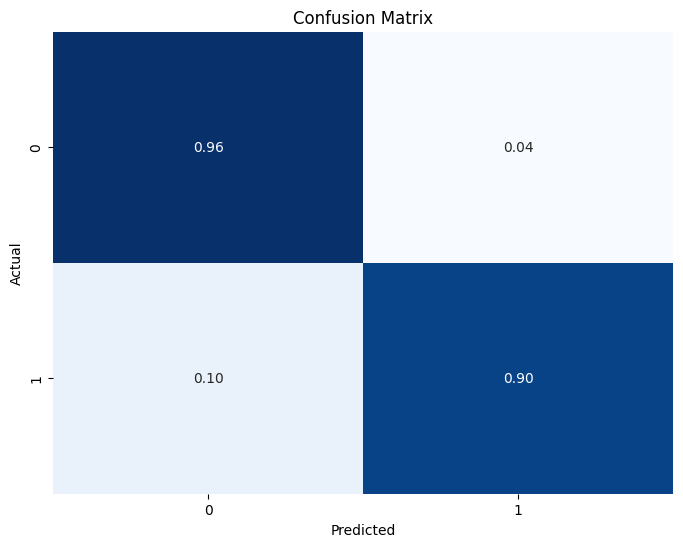

In [7]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Over Sampling - No selection

In [8]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



Reloading Tuner from ./shallow_nn_out/over_no_sel_shallow_nn/tuner0.json


In [9]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
y_pred = model.predict(X_test) > 0.5
test_loss, test_acc = model.evaluate(X_test, y_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')

#save the test recall, f1, precision and accuracy
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_test_recall_f1_precision_accuracy.txt', 'w') as f:
    f.write(f'Test recall: {recall}\nTest f1: {f1}\nTest precision: {precision}\nTest accuracy: {accuracy}\n')

clear_output()

print("Test Set")
print(f'F1 score: {f1}')
print(f'Accuracy score: {test_acc}')
print(f'Loss score: {test_loss}')
print(f'Precision score: {precision}')
print(f'Recall score: {recall}')



Test Set
F1 score: 0.764367816091954
Accuracy score: 0.9991773962974548
Loss score: 0.009276540018618107
Precision score: 0.7556818181818182
Recall score: 0.7732558139534884


# Plot of Training and Validation Accuracy/Loss

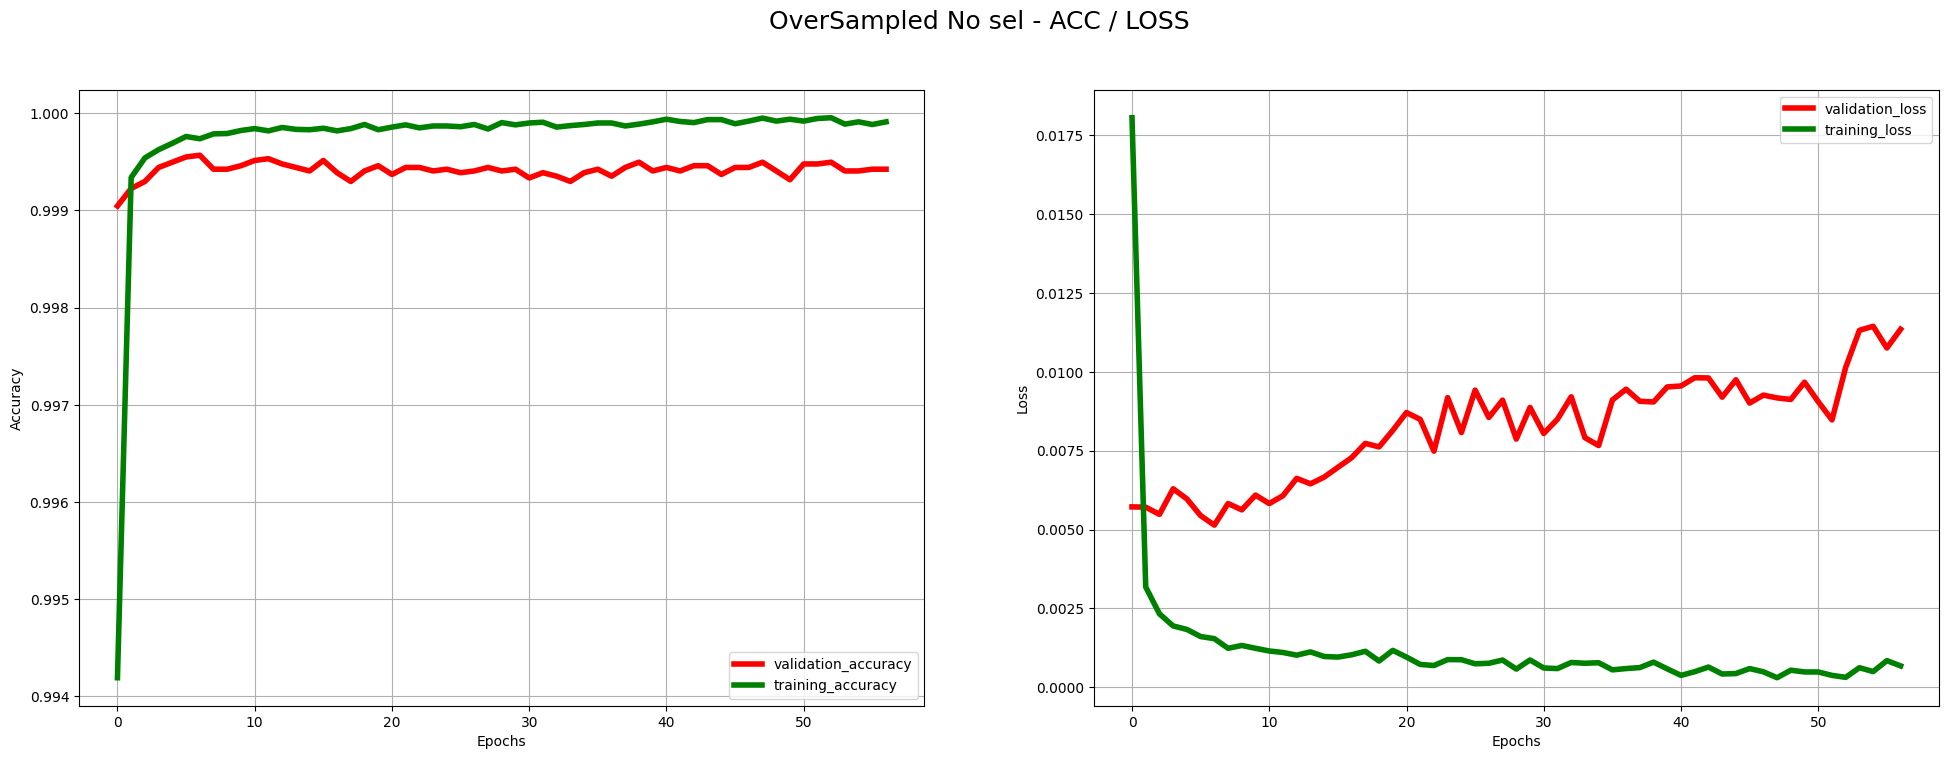

In [10]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step


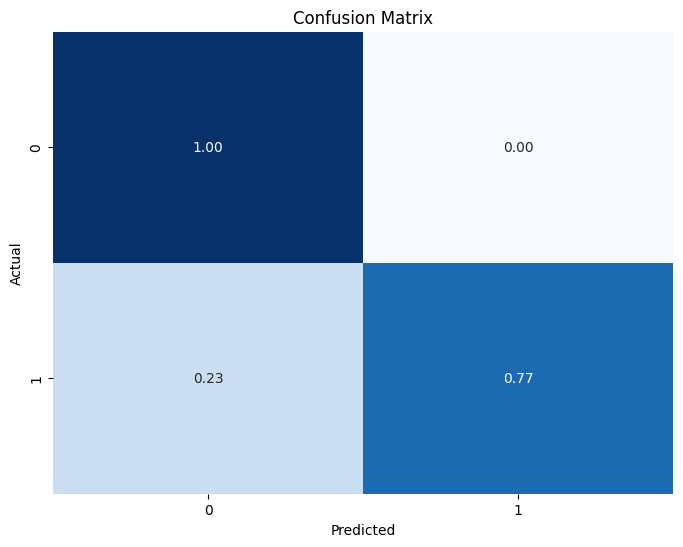

In [11]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# New builder

In [12]:

def build_best_under_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_under_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/under_best_sel_shallow_nn/tuner0.json


## Under Sampling - Best selection

In [13]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
y_pred = model.predict(under_sampled_best_X_test) > 0.5
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')

#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_test_recall_f1_precision_accuracy.txt', 'w') as f:
    f.write(f'Test recall: {recall}\nTest f1: {f1}\nTest precision: {precision}\nTest accuracy: {accuracy}\n')

clear_output()

print("Test Set")
print(f'F1 score: {f1}')
print(f'Accuracy score: {test_acc}')
print(f'Loss score: {test_loss}')
print(f'Precision score: {precision}')
print(f'Recall score: {recall}')

Test Set
F1 score: 0.1393596986817326
Accuracy score: 0.981661856174469
Loss score: 0.12885212898254395
Precision score: 0.07581967213114754
Recall score: 0.8604651162790697


# Plot of Training and Validation Accuracy/Loss

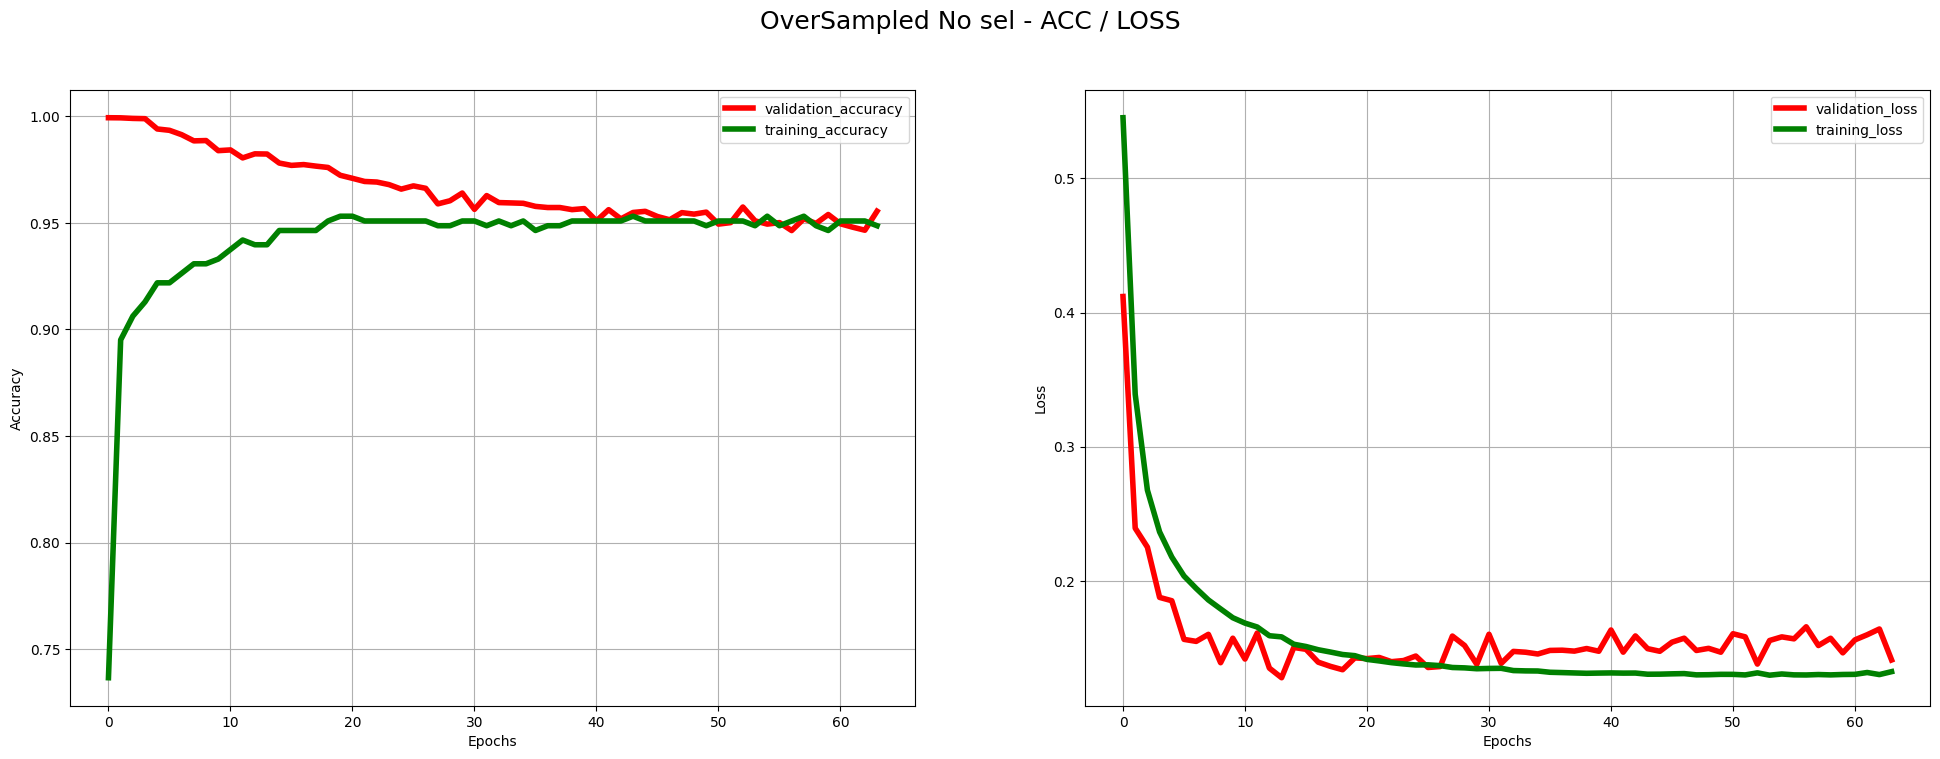

In [14]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 619us/step


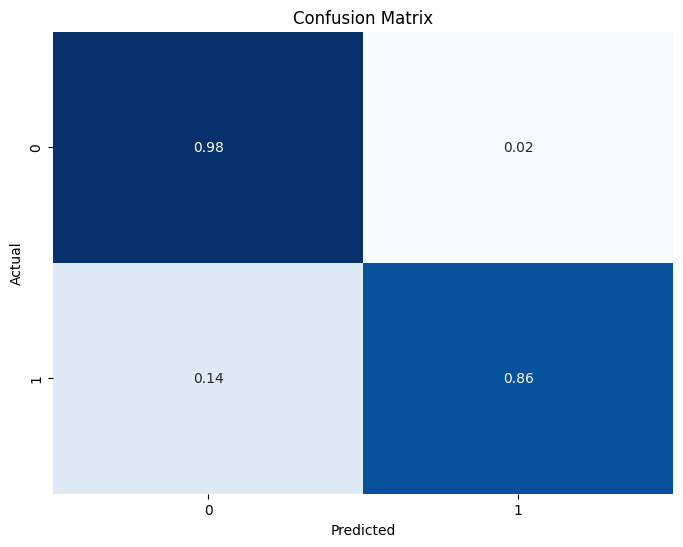

In [15]:
y_pred = model.predict(under_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# New Builder

In [16]:

def build_best_over_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_over_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/over_best_sel_shallow_nn/tuner0.json


## Over Sampling - Best selection

In [17]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
print("GPUS: ", tf.config.list_physical_devices('GPU'))

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
y_pred = model.predict(under_sampled_best_X_test) > 0.5
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')

#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_test_recall_f1_precision_accuracy.txt', 'w') as f:
    f.write(f'Test recall: {recall}\nTest f1: {f1}\nTest precision: {precision}\nTest accuracy: {accuracy}\n')

clear_output()

print("Test Set")
print(f'F1 score: {f1}')
print(f'Accuracy score: {test_acc}')
print(f'Loss score: {test_loss}')
print(f'Precision score: {precision}')
print(f'Recall score: {recall}')

Test Set
F1 score: 0.7258064516129032
Accuracy score: 0.9989767670631409
Loss score: 0.009790155105292797
Precision score: 0.675
Recall score: 0.7848837209302325


# Plot of Training and Validation Accuracy/Loss

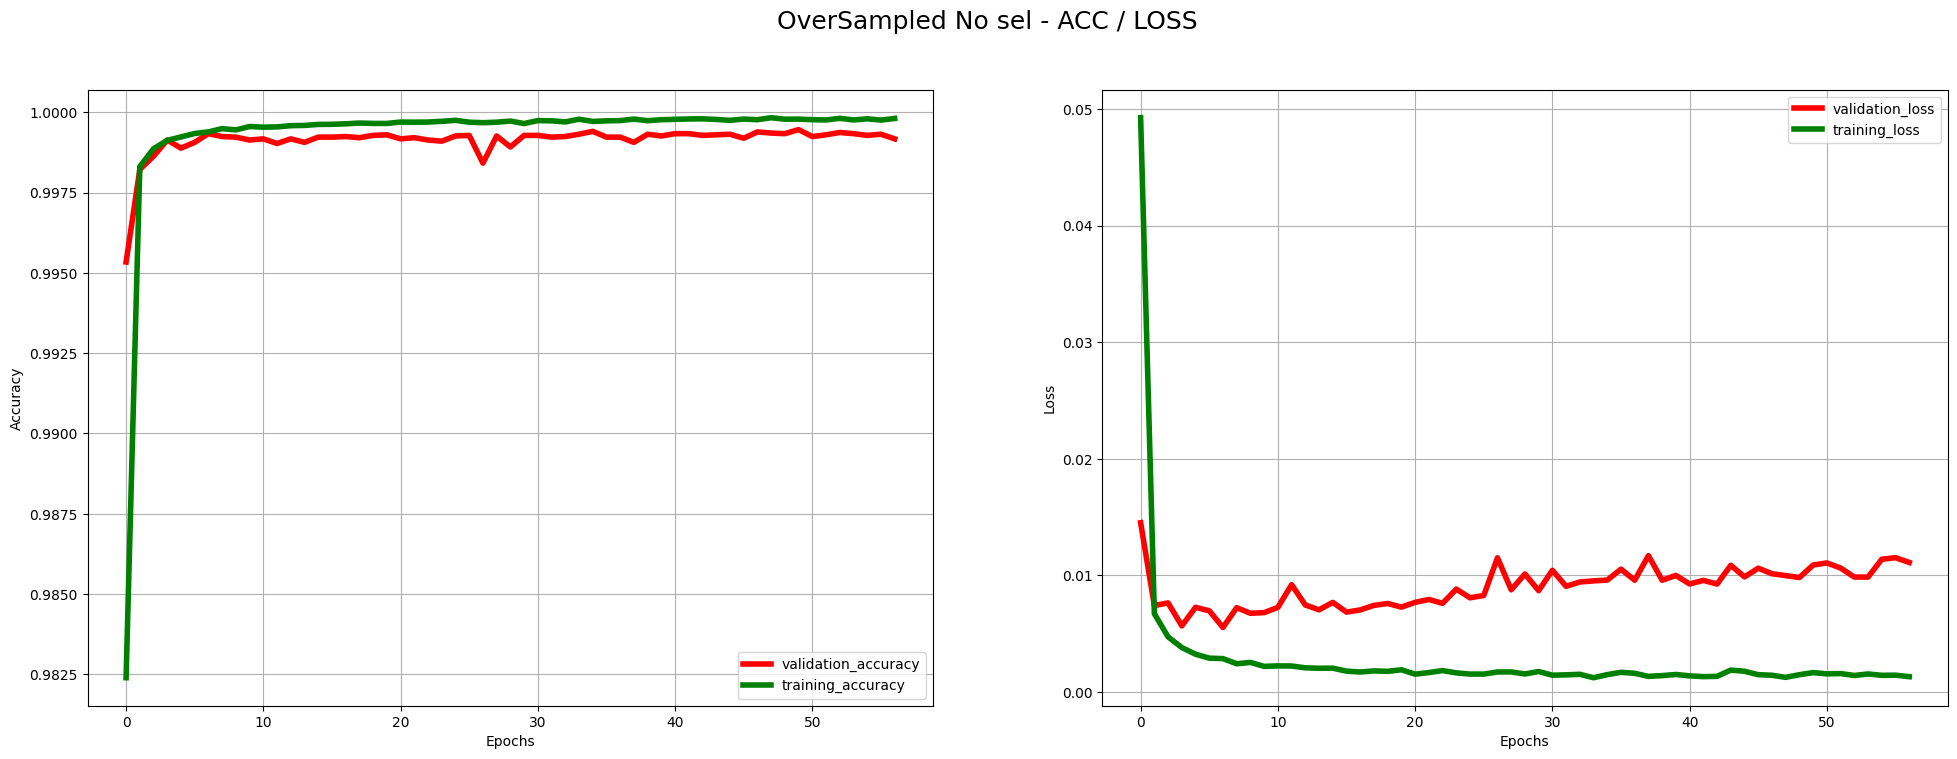

In [18]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

   1/3116 ━━━━━━━━━━━━━━━━━━━━ 1:13 24ms/step

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step


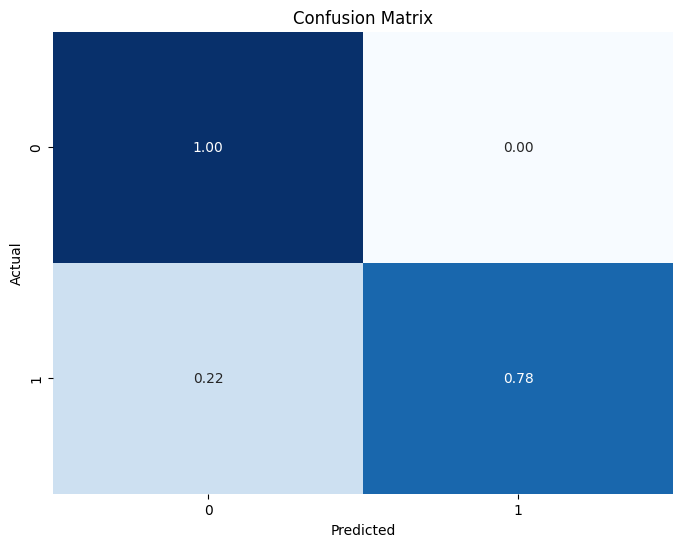

In [19]:
y_pred = model.predict(over_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()